In [2]:
!pip install torchfunc
## For hooks recorder-> to catch the forward pass

In [3]:
import torch
import torchfunc
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(28)
torch.manual_seed(28)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091],std=[0.24703223 ,0.24348513, 0.26158784])
])
batch_size = 64
### Download the data (online data)  ###
train_set = datasets.CIFAR10('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transform),
    batch_size=batch_size)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Extracting data/cifar-10-python.tar.gz to data


# CNN Model

In [5]:
class CnnModel(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CnnModel, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.02),
            
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            
            # Conv Layer block 4
            #nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.BatchNorm2d(512),            
            nn.ReLU(inplace=True),
            #nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )


        self.fc_layer = nn.Sequential(
            nn.Linear(1024,512), # For 4 blocks of CNN
            #nn.Linear(4096, 1024), # for 3 blocks of CNN
            #nn.Linear(128*8*8, 4096), # if we use 2 blocks of CNN
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            #nn.Linear(1024, 512),# for 3 blocks of CNN
            #nn.Linear(4096, 512), # if we use 2 blocks of CNN
            #nn.ReLU(inplace=True), # for 2 & 3 blocks of CNN
            #nn.Dropout(p=0.4), # for 2 & 3 blocks of CNN
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.conv_layer(x)        
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [6]:
def train(model, trainloader, lr=0.001, momentum=0.9, epochs=10):
    model.train()
    # create optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=0.05)
    #optimizer = optim.Adam(model.parameters(),lr =lr,weight_decay =0.05)

    # define loss function
    criterion = nn.CrossEntropyLoss()

    num_iters = 0
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            images, labels = data
            # send to device
            images, labels = images.to(device), labels.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward, backward and optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            num_iters += 1
            losses.append(loss.item())
            
            
        print('Epoch: {0}, loss:{1:.4f}'.format(epoch,loss.item()))

    # losses per iteration
    return losses

def test(model, testloader):
    model.eval()
    total = len(testloader.dataset)
    correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # send to device
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


def plot_losses(losses):
    x = list(range(len(losses)))
    y = losses
    plt.title("Loss per Iteration(avg pooling)")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.plot(x, losses)
    plt.show()

Epoch: 0, loss:0.7546
Epoch: 1, loss:0.7549
Epoch: 2, loss:1.0379
Epoch: 3, loss:0.8109
Epoch: 4, loss:0.4684
Epoch: 5, loss:0.6937
Epoch: 6, loss:0.7484
Epoch: 7, loss:0.3891
Epoch: 8, loss:0.6373
Epoch: 9, loss:0.4604
Train accuracy:  84.224
Test accuracy: 79.96


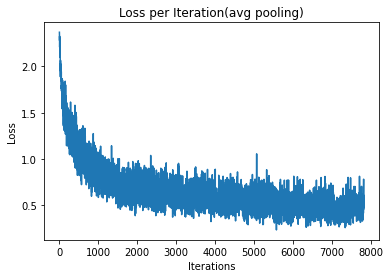

In [7]:
model= CnnModel().to(device)
losses = train(model,train_loader)
train_acc = test(model, train_loader)                                
test_acc = test(model, test_loader)
print("Train accuracy: ", train_acc)
print("Test accuracy:", test_acc)
plot_losses(losses)

# Visualize kernel of each Conv filter

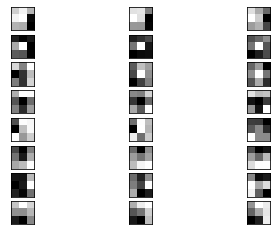

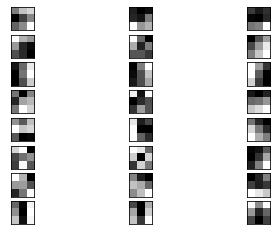

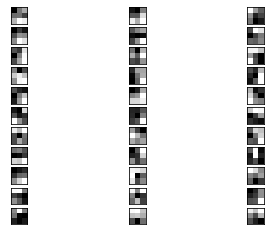

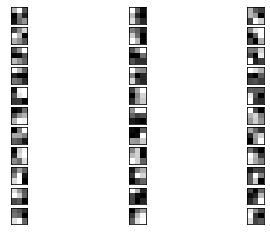

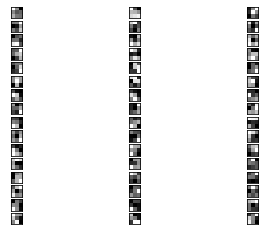

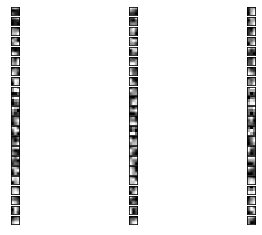

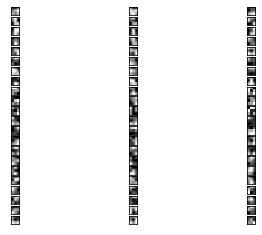

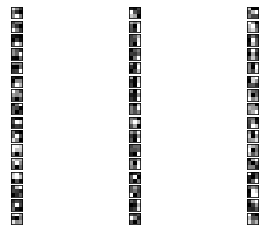

In [10]:
for mod in model.modules():
    if isinstance(mod, nn.modules.conv.Conv2d):
        weight_data = mod.weight.data.detach().cpu()
        #print("Shape of the weights : ", weight_data.size())
        num = weight_data.size(0)
        num_plot = int(math.floor(math.sqrt(num)))

        ### Normalize to visualize the weights
        w_min,w_max = weight_data.min(),weight_data.max()
        #print("Min val of Weight: {0:.4f}\n Max val of Weight: {1:.4f}".format(w_min,w_max))
        weights = weight_data-w_min/(w_max-w_min)
                
        # plot first few filters
        ix = 1
        for i in range(num_plot):
            # Get the Filter
            filters = weights[i,:,:,:]
            # Plotting each channel separately
            for j in range(3):
                # specify subplot and turn of axis
                ax = plt.subplot(num_plot,3,ix)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(filters[j,:,:],cmap='gray')
                ix +=1
        
        plt.show()

# Visualize activations after each Conv filter

Layer 0, shape of the layer torch.Size([1, 3, 32, 32])
Layer 1, shape of the layer torch.Size([1, 64, 32, 32])
Layer 2, shape of the layer torch.Size([1, 64, 16, 16])
Layer 3, shape of the layer torch.Size([1, 128, 16, 16])
Layer 4, shape of the layer torch.Size([1, 128, 8, 8])
Layer 5, shape of the layer torch.Size([1, 256, 8, 8])
Layer 6, shape of the layer torch.Size([1, 512, 4, 4])
Layer 7, shape of the layer torch.Size([1, 512, 4, 4])
Size of Activation Map:  torch.Size([64, 32, 32])
Number of Channels:  64


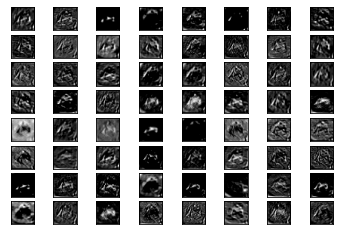

Size of Activation Map:  torch.Size([64, 16, 16])
Number of Channels:  64


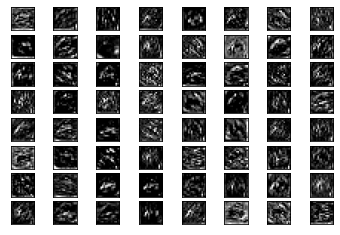

Size of Activation Map:  torch.Size([128, 16, 16])
Number of Channels:  128


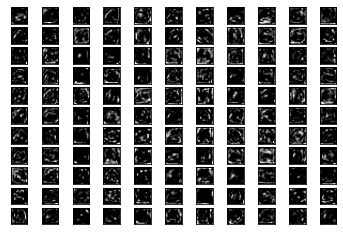

Size of Activation Map:  torch.Size([128, 8, 8])
Number of Channels:  128


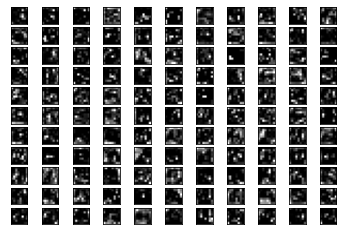

Size of Activation Map:  torch.Size([256, 8, 8])
Number of Channels:  256


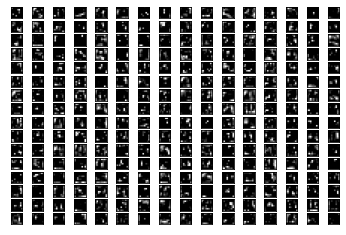

Size of Activation Map:  torch.Size([512, 4, 4])
Number of Channels:  512


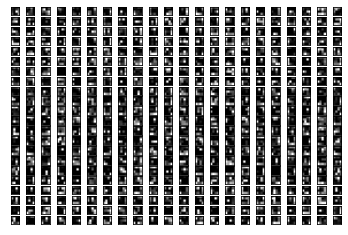

Size of Activation Map:  torch.Size([512, 4, 4])
Number of Channels:  512


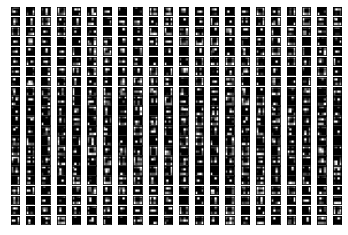

In [9]:
data,_ = train_set[0]
data.unsqueeze_(0)   # There is no batch size, that's why adding extra dimension '1' as batch size
data = data.to(device)

recorder = torchfunc.hooks.recorders.ForwardPre()
recorder.modules(model,types = nn.Conv2d)
output= model(data)

activation_data={}
for i in range(len(recorder.data)):
    activation_data['conv'+str(i)]= recorder.data[i][0].detach()
    print('Layer {0}, shape of the layer {1}'.format(i,recorder.data[i][0].size()))


## For all conv layers
for i in range(1,len(activation_data)):
    ix =1
    act = activation_data['conv'+str(i)].squeeze().cpu()  # Get rid of extra dimension '1' which was used as batch size & assign the var to cpu 
    #print("Size of Activation Map: ",act.size()) 
    #print("Number of Channels: ",act.size(0)) 
    num = act.size(0)
    num_plot = int(math.floor(math.sqrt(num)))
    fig = plt.figure()  # create a figure object
    for _ in range(num_plot):
        for _ in range(num_plot):
            ax = fig.add_subplot(num_plot,num_plot,ix)
            ax.set_xticks([])
            ax.set_yticks([])      
            plt.imshow(act[ix-1,:,:],cmap='gray')
            ix += 1
    
    plt.savefig(str('conv'+str(i))+".png", bbox_inches="tight")
    plt.show()

